# Import

In [ ]:
%pip install kagglehub openpyxl imbalanced-learn seaborn torch

In [ ]:
import kagglehub as kg
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import VotingClassifier

from helper.plot import plot_attr_label, plot_attributes
from helper.transform import transform_pca, remove_outliers_zscore, remove_outliers_db, remove_outliers_isf, bin_attributes_mean, bin_attributes_median, regression_reduce_noise
from helper.transform import remove_label_noise_ensemble_filter, remove_label_noise_cross_validated_committees_filter, remove_label_noise_iterative_partitioning_filter
from helper.train import run_models, test_models

# Load data

In [ ]:
path = kg.dataset_download("muratkokludataset/dry-bean-dataset")
file_name = '/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx'
print("Downloaded at: ", path)

In [ ]:
data = pd.read_excel(path+file_name)

In [ ]:
data

In [ ]:
def get_onehot(class_count, class_ind):
    rez = np.zeros(class_count)
    rez[class_ind] = 1
    return rez

unique_vals = np.unique(data['Class'])
class_map_oh = {x: get_onehot(len(unique_vals), i) for i, x in enumerate(unique_vals)}
class_map_label = {x: i for i, x in enumerate(unique_vals)}

In [ ]:
data['Class_OneHot'] = data['Class'].apply(lambda x: class_map_oh[x])
data['Class_Label'] = data['Class'].apply(lambda x: class_map_label[x])
data.drop(axis=1, labels=['Class'], inplace=True)

In [ ]:
data

# Train/Test split

Odmah izdvajamo train i test set u razmeri 70:30

In [ ]:
train_perc = 0.8
test_perc = 1 - train_perc

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=test_perc, random_state=42)

# Perform the split
for train_idx, test_idx in split.split(data, data['Class_Label']):
    train_set = data.iloc[train_idx]
    test_set = data.iloc[test_idx]

print('Train size: ', len(train_set), 'x', len(train_set.iloc[0]))
print('Test size: ', len(test_set), 'x', len(test_set.iloc[0]))

# EDA

In [ ]:
train_set

In [ ]:
train_set.describe()

Atributi 
- Area
- Perimeter
- Major Axis Length
- Minor Axis Length
- AspectRation
- ConvexArea
- EquivDiameter 

imaju dosta velike vrednosti dok ostali atributi su u range $[0-1]$

In [ ]:
plot_attributes(train_set)

Sa grafikona vidimo da vrednosti atributa ne prate normalnu raspodelu.\
Atributi kao ShapeFactor4 i Solidity imaju velike repove. Zato ćemo tokom preprocesiranja normalizovati raspodele.\
Pored toga skup podataka nije balansiran:
- Klasa 1 je slabo zastupljena sa manje od 500 instanci, klasa 0 ima oko 1000 dok klasa 3 dominira sa oko 2500 instanci
- Zato ćemo izvršiti under i oversampling na oko 1-1.5 hiljade instanci

In [ ]:
plot_attr_label(train_set)

Po grafikonu iznad vidimo da se klasa 1 karakteriše visokim vrednostima Major i Minor axis length, EquivDiameter, ConvexArea, Area i Perimeter. Pored toga ima male vrednosti ShapeFactor1.

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su nebalansirani, potrebno je under i over sample-ovati na oko 1-1.5 hiljade instanci</li>
<li>Atribute je potrebno normalizovati, a neke i skalirati kao što su Area</li>
<li>Klasa 1 je nedovoljno zastupljena ali lako prepoznatljiva po atributima koji imaju visoke vrednosti kao što je Area</li>
</ul>
</div>


# Normalizacija i Standardizacija

In [ ]:
y_oh = train_set['Class_OneHot']
y_lab = train_set['Class_Label']
y_test = test_set['Class_Label']
X = train_set.drop(axis = 1, labels=['Class_OneHot','Class_Label'])
X_test = test_set.drop(axis = 1, labels=['Class_OneHot','Class_Label'])

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X)
X_test_pt = pt.transform(X_test)

In [ ]:
scaler = MinMaxScaler()
train_set_scaled = scaler.fit_transform(X_pt)
test_set_scaled = scaler.fit_transform(X_test_pt)
X_pt = pd.DataFrame(train_set_scaled, columns=X.columns)
X_test_pt = pd.DataFrame(test_set_scaled, columns=X_test.columns)

In [ ]:
plot_attributes(X_pt)

Podaci sada prate raspodele dosta bliže normalnoj raspodeli

In [ ]:
plot_attr_label(X_pt, labels=y_lab)

# Under/OverSampling

In [ ]:
target_samples = 1250 # Pick a number in the range

# Oversample with SMOTE and undersample with RandomUnderSampler
smote = SMOTE(sampling_strategy=lambda y: {k: max(target_samples, v) for k, v in Counter(y).items() if v < target_samples}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pt, y_lab)

under = RandomUnderSampler(sampling_strategy=lambda y: {k: min(target_samples, v) for k, v in Counter(y).items() if v > target_samples}, random_state=42)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['target'] = y_resampled

In [ ]:
df_balanced['target_oh'] = df_balanced['target'].apply(lambda x: get_onehot(len(np.unique(df_balanced['target'])), x))

In [ ]:
df_balanced

Sada imamo tačno 1250 instaci u svakoj klasi

<div style="background-color:#12AA12; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su sada izbalansirani - svaka klasa ima 1250 instanci</li>
<li>Atribute su normalizovani i skalirani na 0-1</li>
</ul>
</div>

# Baseline performanse

In [ ]:
X_t = df_balanced.drop(axis=1,labels=['target','target_oh'])
y = df_balanced['target']

all_res = []
all_res_change=[]

In [ ]:
X_t

In [ ]:
feature_num = len(X_t.values[0])
rfc = (RandomForestClassifier(n_jobs=4), "RandomForestClassifier")
svc = (SVC(), "SVC")
gbc = (GradientBoostingClassifier(), "GradientBoostingClassifier")
abc = (AdaBoostClassifier(), "AdaBoostClassifier")
knc = (KNeighborsClassifier(), "KNeighborsClassifier")
mlp = (MLP(hidden_layer_sizes=[16,16,16], alpha=0), "MLP")

models = [rfc, svc, gbc, abc, knc, mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
_, _, baseline_att_noise, baseline_class_noise = run_models(X_t, y, models, all_res, all_res_change, transforms=[], title="Baseline")

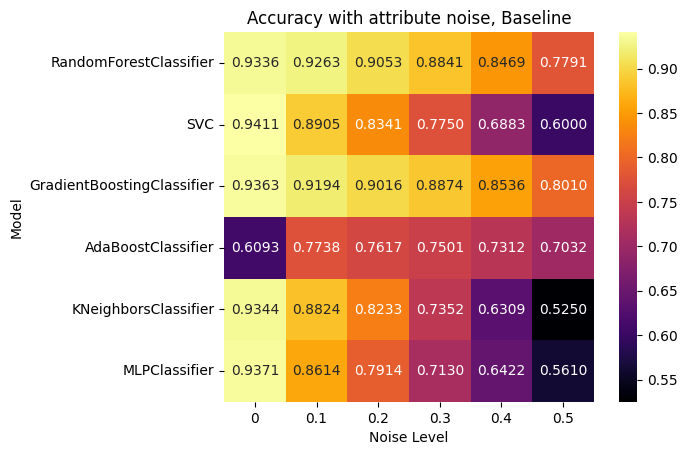
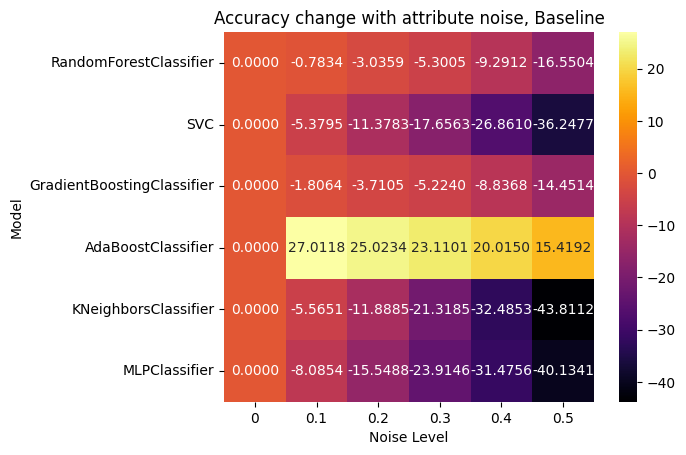

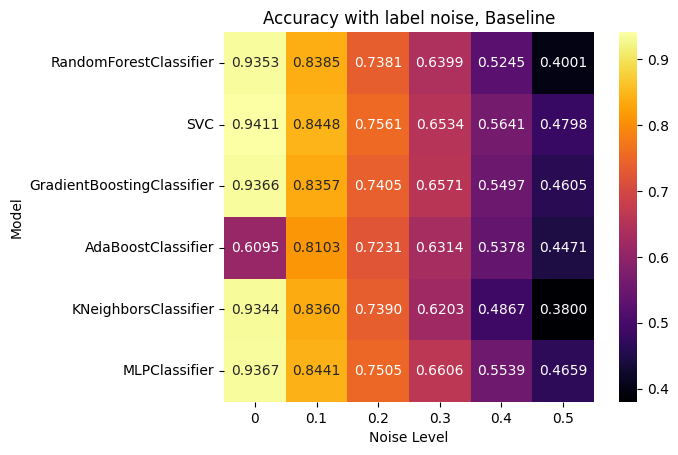
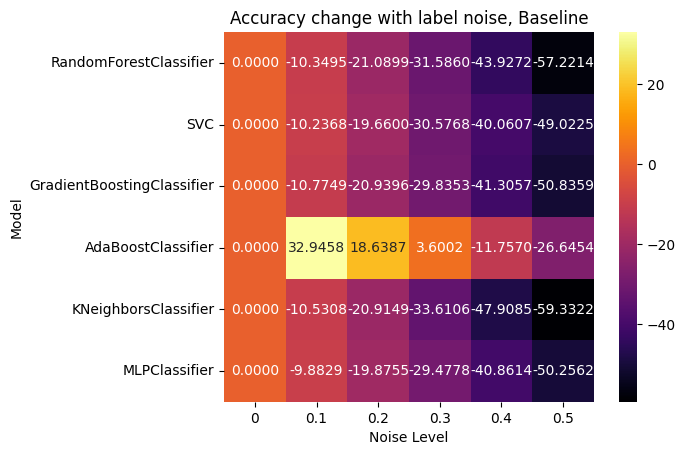

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Kod svih modela se može primetiti da imaju poteškoća kod predviđanja instanci koje se nalaze u gustim oblastima gde ima dosta mešanja instanca različitih klasa.</li>
<li>Potencijalno je poboljšanje sa regularizacijom modela</li>
<li>Pored toga postoje instance koje su dosta odvojene od ostatka instance što bi moglo da reši uklanjanje outlier-a</li>
<li>Na heatmap-i vidimo preciznost modela kao i promene u preciznosti usled povećanja šuma</li>
<li>Svi modeli imaju dosta dobre performanse (oko 93% preciznosti) kada nema šuma, dok povećanjem šuma se preciznost smanjuje</li>
<li>RandomForest i GradientBoosting klasifikatori su za sada najotporniji na šum labela (pad oko 15-20% kada pola skupa se zameni nasumičnim vrednostima), dok su se perceptron i KNeighbors klasifikator najgore pokazali</li>
<li>Svi modeli imaju velik pad u preciznosti kada se pojavi šum medju labelama, što se vidi i na dijagramima sa granicama odlučivanja</li>
<li>AdaBoost model postiže čak bolje performanse kada se unese malo šuma. Šum ovde služi kao način regularizacije modela.</li>
</ul>
</div>

# Regularizacija modela

In [ ]:
feature_num = len(X_t.values[0])
rfc = (RandomForestClassifier(n_jobs=4, max_depth=5, max_features='log2'), "RandomForestClassifier")
svc = (SVC(C = 3, kernel='linear'), "SVC")
gbc = (GradientBoostingClassifier(max_features='log2'), "GradientBoostingClassifier")
abc = (AdaBoostClassifier(), "AdaBoostClassifier")
knc = (KNeighborsClassifier(n_neighbors=10), "KNeighborsClassifier")
mlp = (MLP(hidden_layer_sizes=[16,16,16], alpha=0.005), "MLP")

models = [rfc, svc, gbc, abc, knc, mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[], title="With regularization")

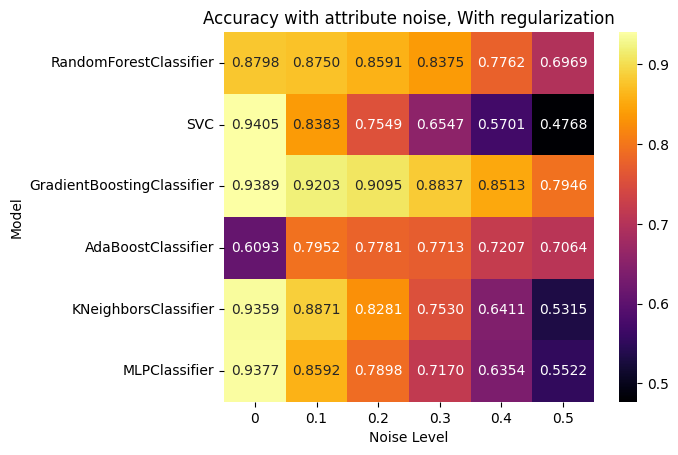
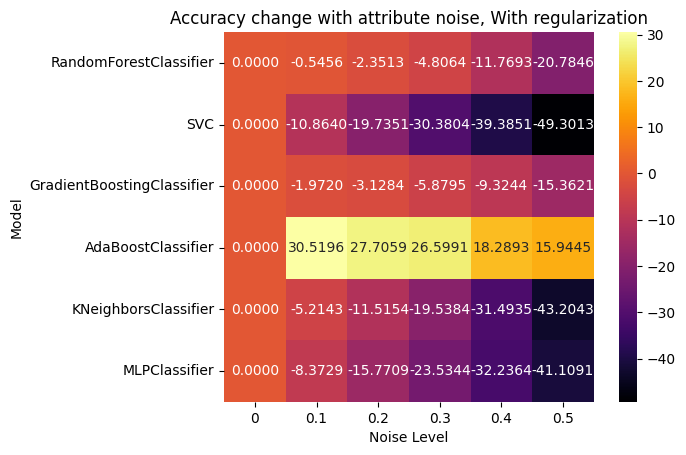

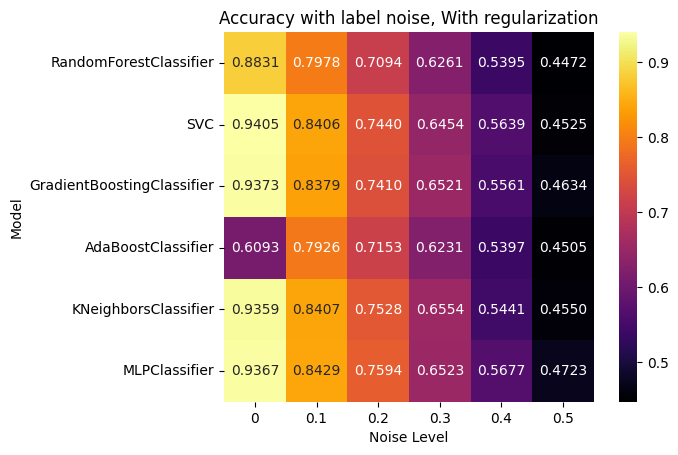
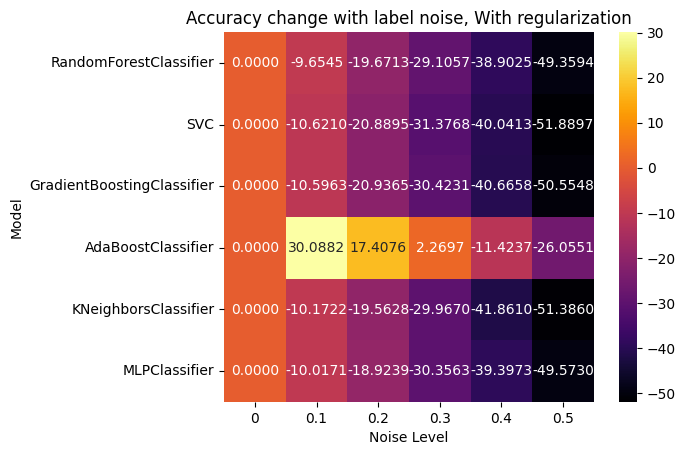

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Regularizacijom modela se u ovom slučaju ne postižu bolji rezultati, čak se često dobijaju i gori</li>
<li>U nekim slučajevima je regularizacija poboljšala performanse, ali poboljšanja nisu značajna</li>
<li>Regularizacija se najbolje pokazala kod perceptrona pa ćemo u konačnom modelu uključiti regularizaciju kod MLP-a</li>
<li>Takođe, regularizacija je pomogla KNeighbors i MLP klasifikatoru kada je prisutan šum labela</li>
</ul>
</div>

# Redukcija dimenzionalnosti

Na dalje će testiranje biti vršeno na sledeći način
- U skup podataka se doda određena količina šuma
- Nad trening podacima se primena neka od tehnika - PCA, uklanjanje outliera, redukcija šuma ili se nad labela primeni otklanjanje šuma labela
- Nad tako dobijenim podacima se vrši trening i procena performansi

In [ ]:
feature_num = 5
rfc = (RandomForestClassifier(n_jobs=4), "RandomForestClassifier")
svc = (SVC(), "SVC")
gbc = (GradientBoostingClassifier(), "GradientBoostingClassifier")
abc = (AdaBoostClassifier(), "AdaBoostClassifier")
knc = (KNeighborsClassifier(), "KNeighborsClassifier")
mlp = (MLP(hidden_layer_sizes=[16,16,16], alpha=0), "MLP")

models = [rfc, svc, gbc, abc, knc, mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[transform_pca], title="With dimensionality reduction")

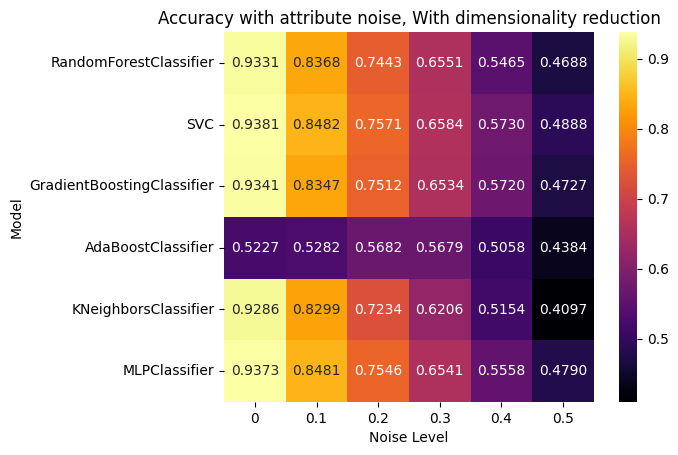
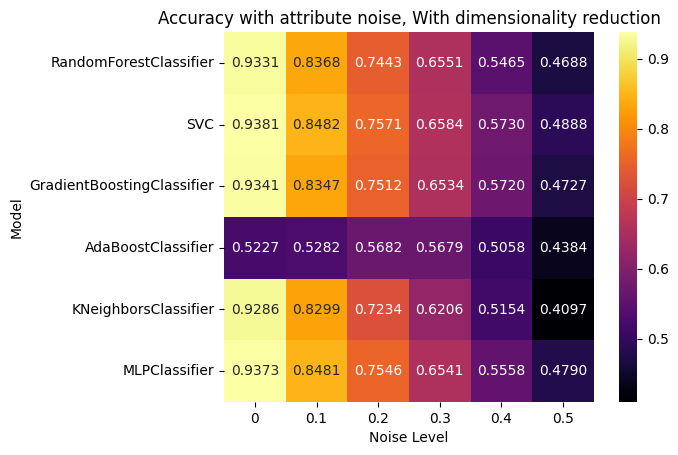

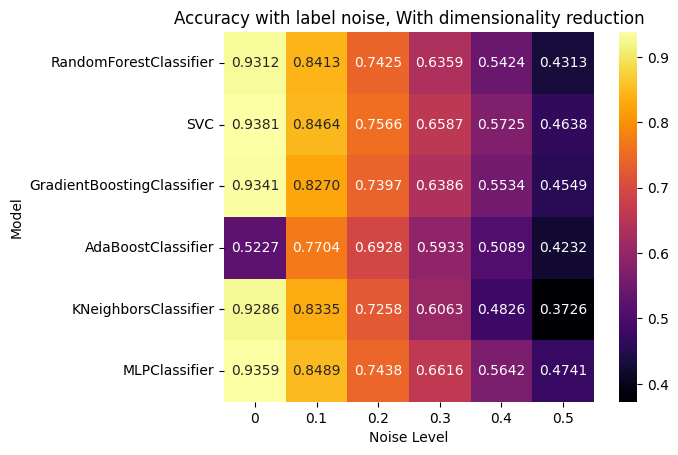
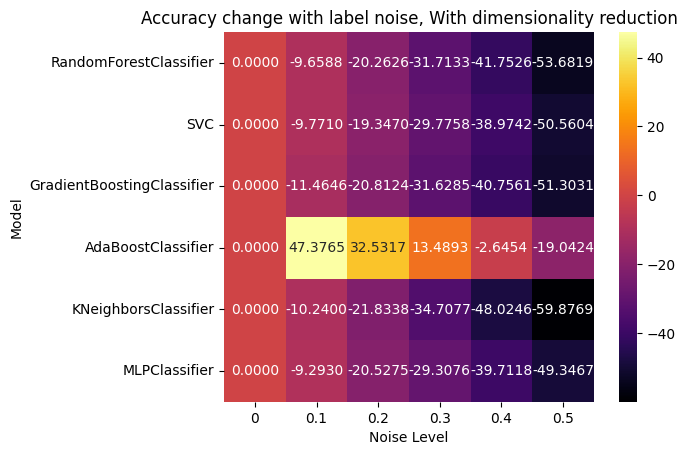

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>U većini slučajeva je redukcija dimenzionalnosti dovela do gorih rezultat, pa je nećemo dalje koristiti</li>
</ul>
</div>

# Izbacivanje outliera

## ZScore

In [ ]:
feature_num = 16
rfc = (RandomForestClassifier(n_jobs=4), "RandomForestClassifier")
svc = (SVC(), "SVC")
gbc = (GradientBoostingClassifier(), "GradientBoostingClassifier")
abc = (AdaBoostClassifier(), "AdaBoostClassifier")
knc = (KNeighborsClassifier(), "KNeighborsClassifier")
mlp = (MLP(hidden_layer_sizes=[16,16,16], alpha=0), "MLP")

models = [rfc, svc, gbc, abc, knc, mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_outliers_zscore], title="With zscore outlier removal")

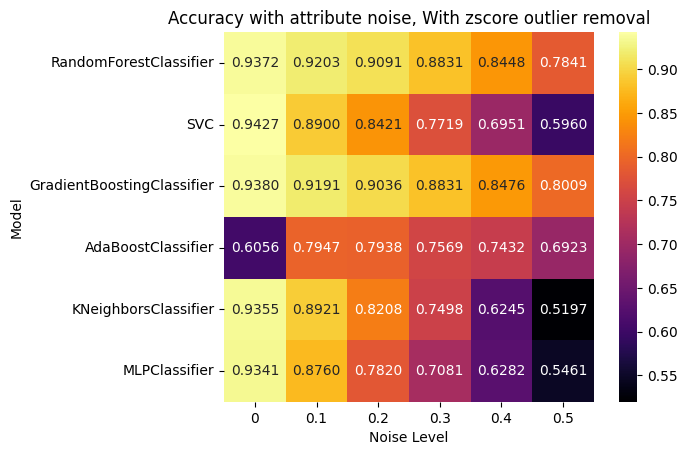
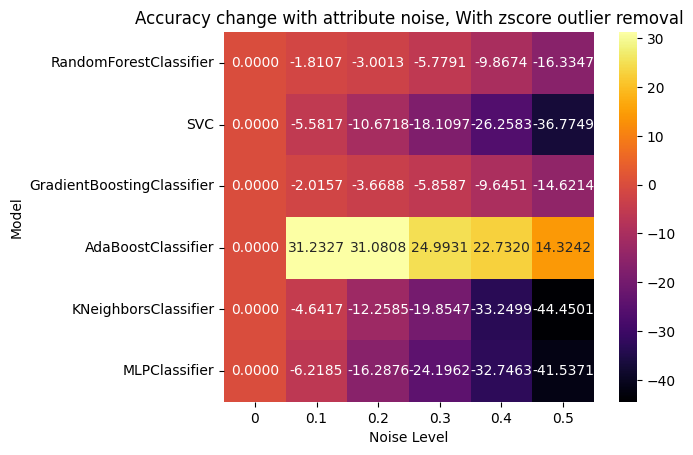

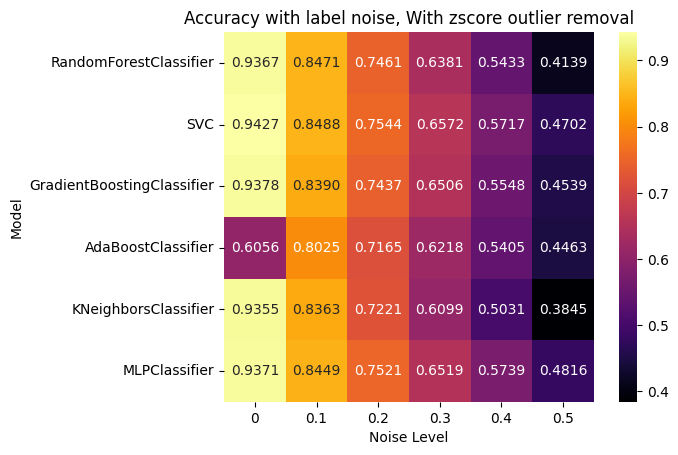
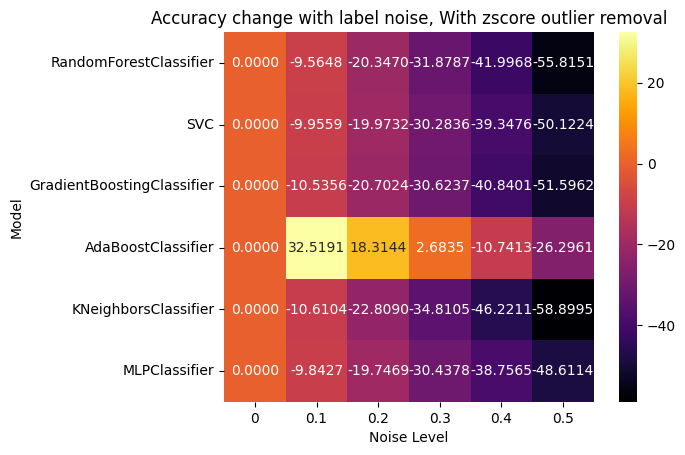

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Izbacivanje outliera zscore metodom ne poboljšava rezultate u slučaju šuma među atributima ali je malo poboljšala rezultate kada je prisutan šum labela</li>
</ul>
</div>

## IsolationForest

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_outliers_isf], title="With isolation forest outlier removal")

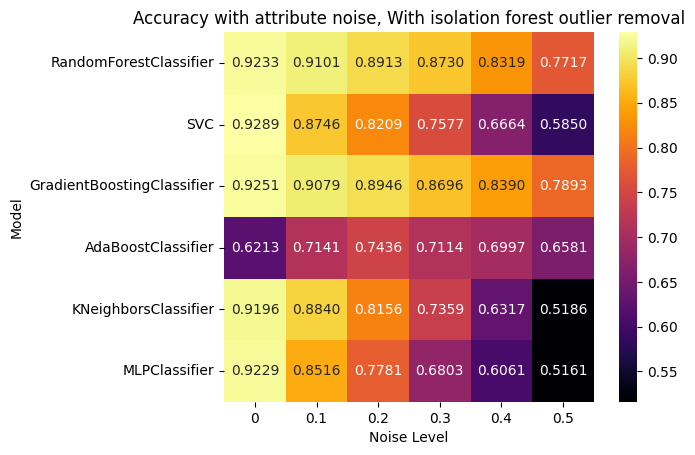
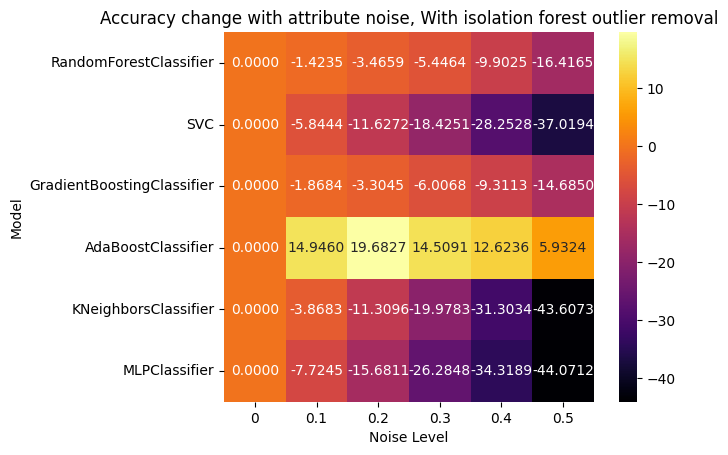

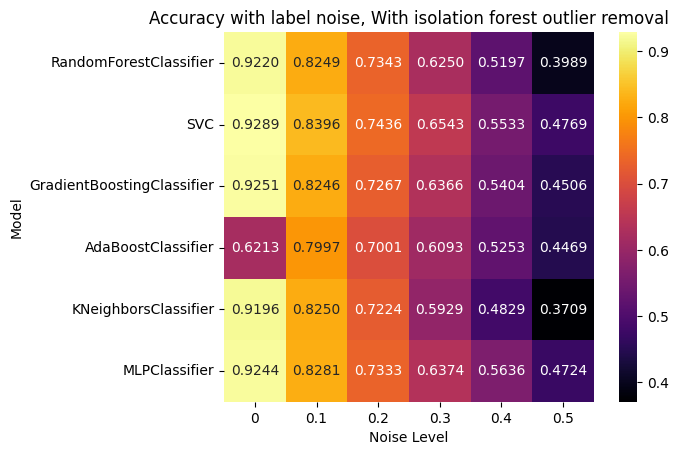
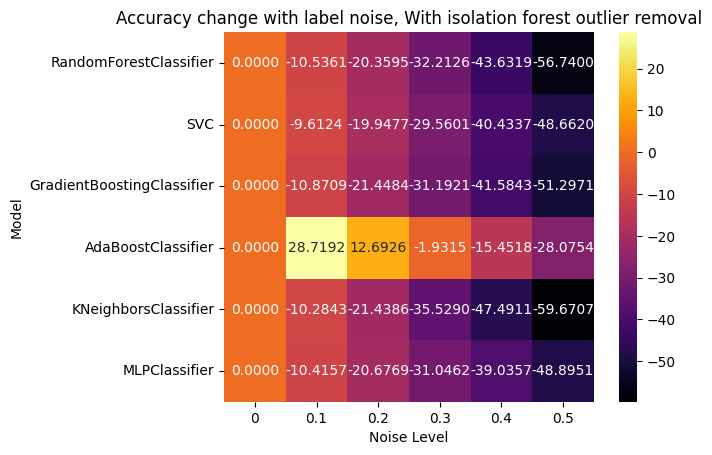

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Izbacivanje outliera Isolation Forest metodom pogoršava rezultate u oba slučaja</li>
</ul>
</div>

## DBSCAN

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_outliers_db], title="With db outlier removal")

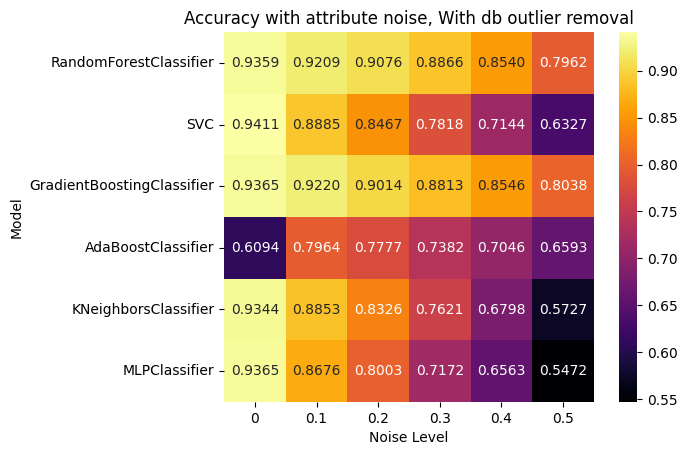
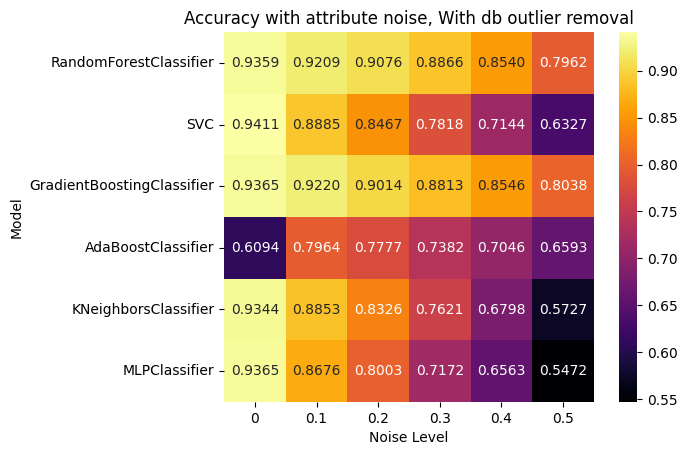

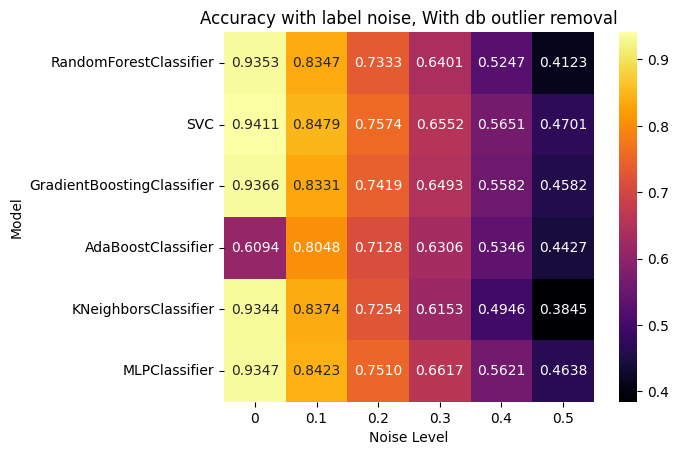
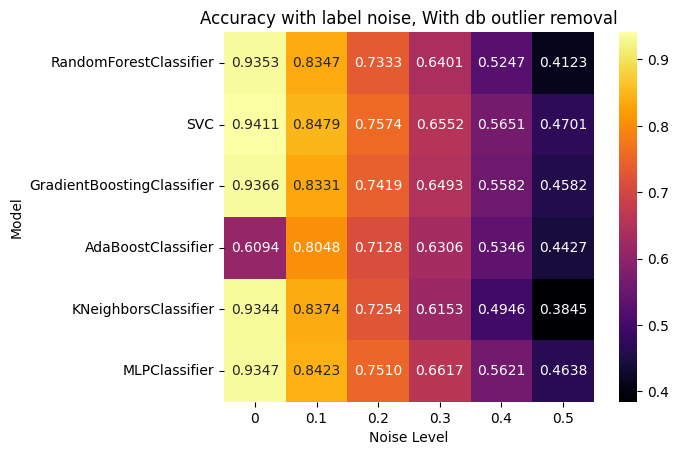

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Izbacivanje outliera DBSCAN metodom poboljšava rezultate u oba slučaja, pa ćemo je koristiti kod konačnog modela</li>
</ul>
</div>

# Redukcija šuma atributa

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[bin_attributes_mean], title="attribute binning, mean, 10 bins")

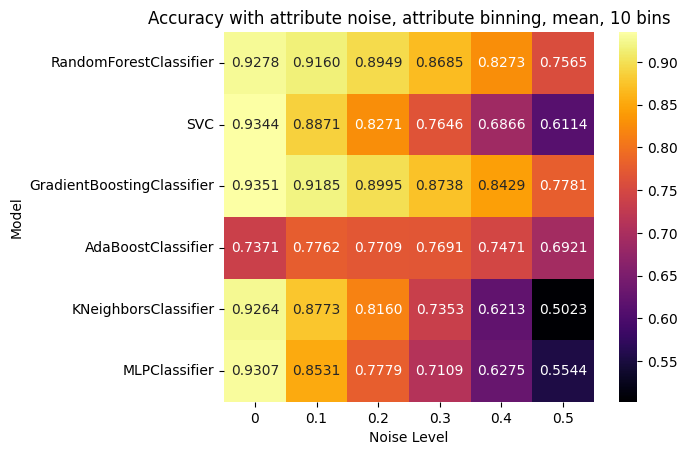
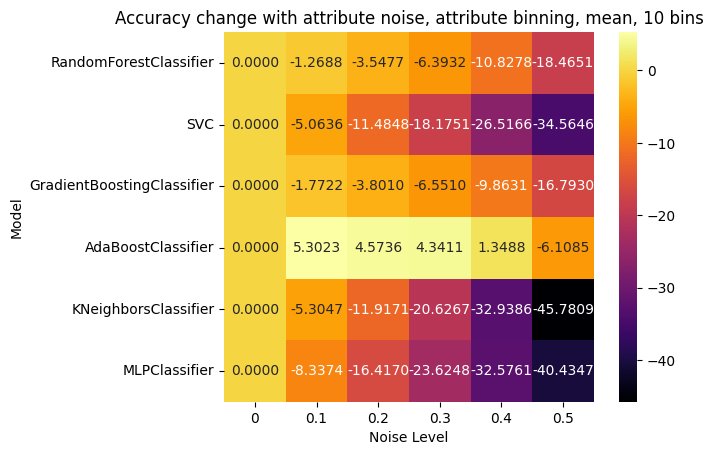

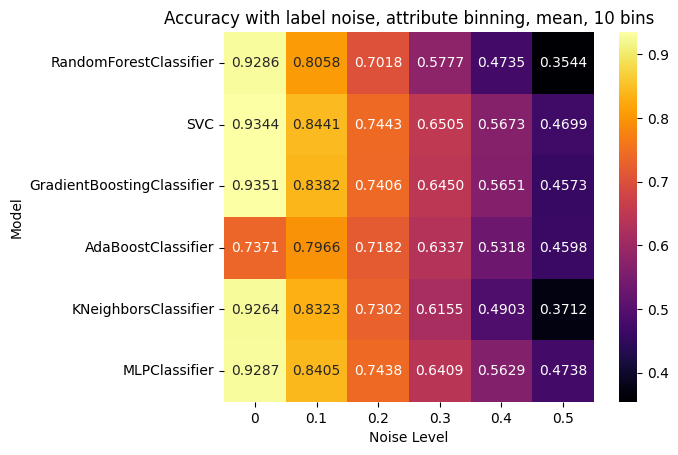
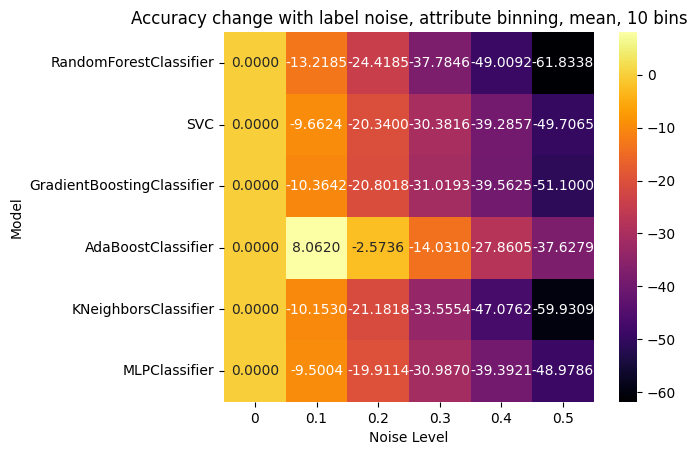

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Binnovanje atributa pomoću proseka bin-ova u oba slučaja pogoršava rezultate</li>
</ul>
</div>

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[bin_attributes_median], title="attribute binning, median, 10 bins")

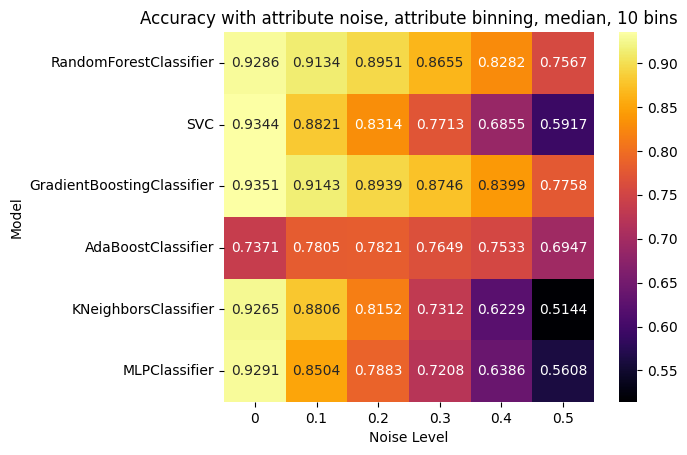
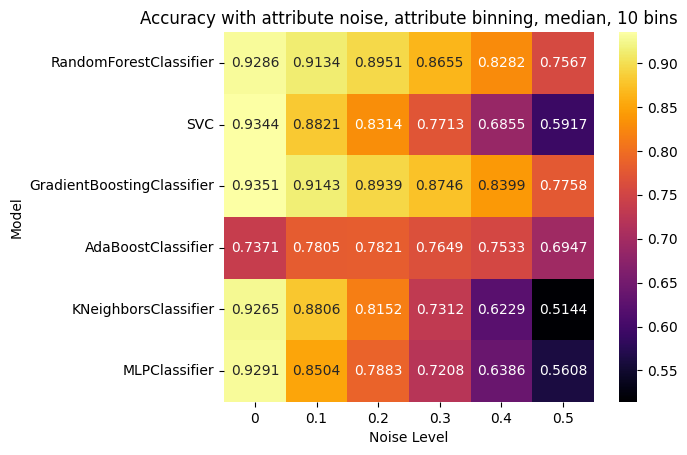

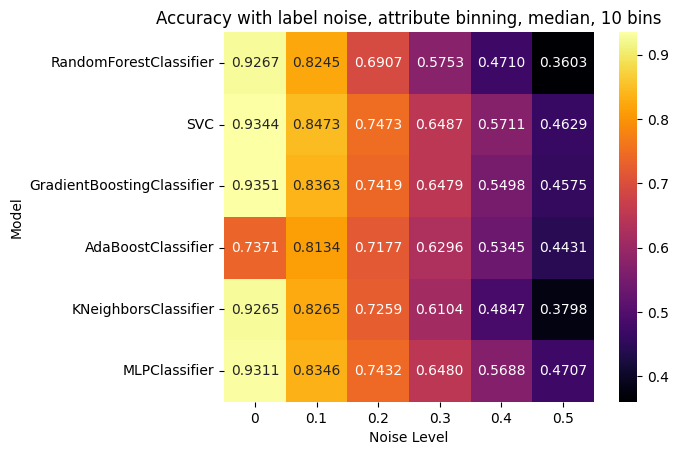
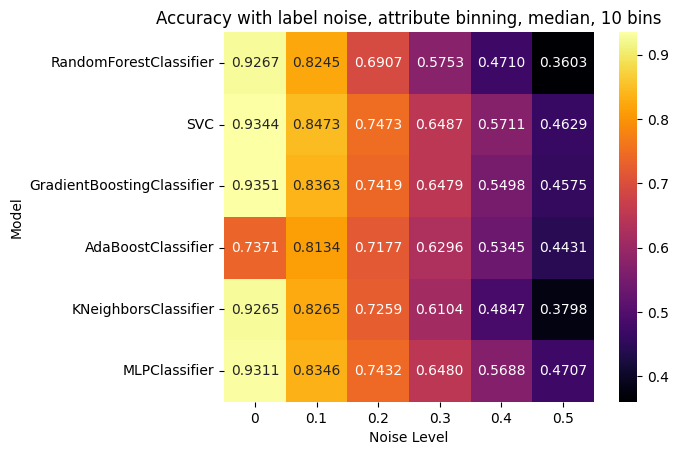

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Binnovanje atributa pomoću medijane bin-ova u oba slučaja pogoršava rezultate</li>
</ul>
</div>

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[regression_reduce_noise], title="reduce attribute noise with regression")

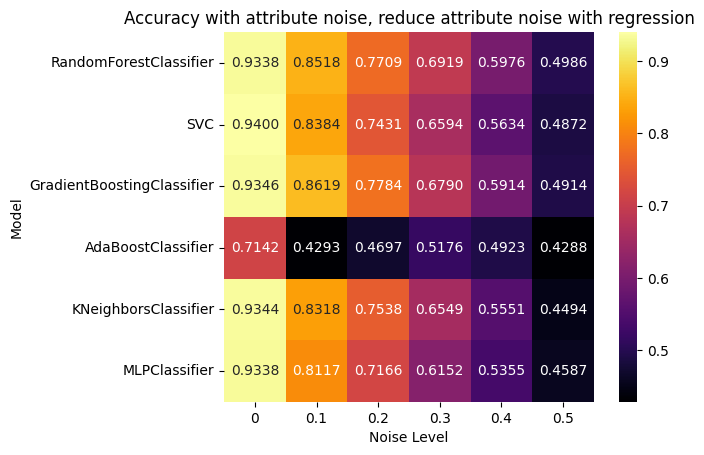
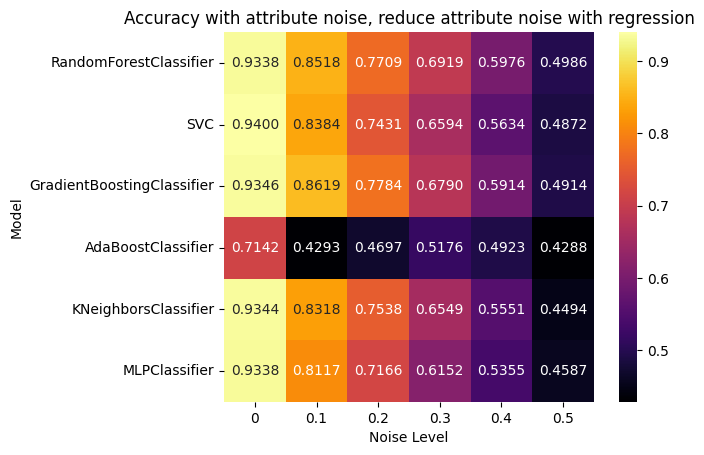

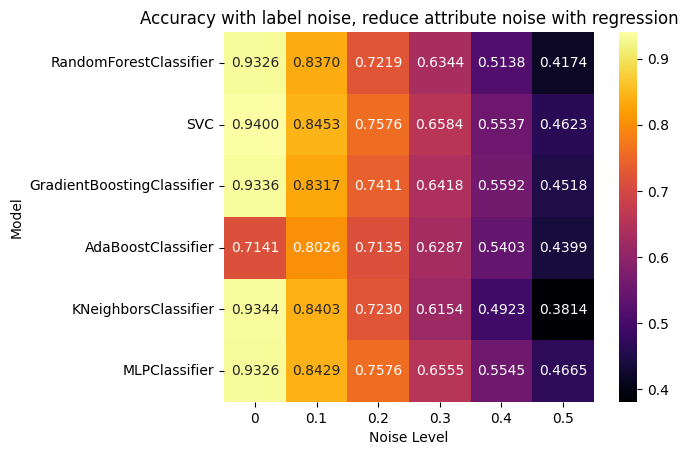
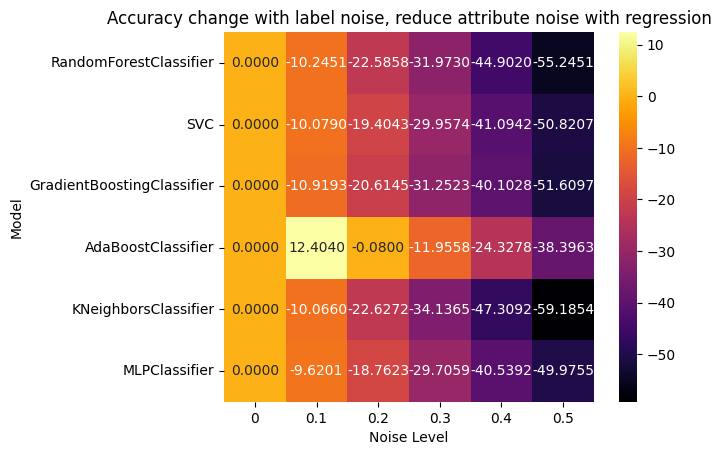

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Uklanjanje šuma pomoću linearne regresije znatno pogoršava performanse modela slučaju šuma među atributima dok kod šuma labela rezultati su neznatno bolji.</li>
</ul>
</div>

# Otklanjanje šuma labela

In [ ]:
mlp = (MLP(hidden_layer_sizes=[16,16,16], alpha=0), False)
models = [rfc, svc, gbc, abc, knc, mlp]

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_label_noise_ensemble_filter], title="Ensemble Filter")

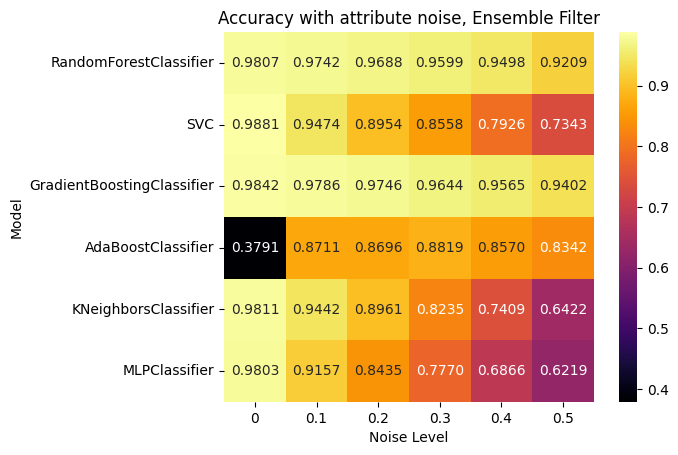
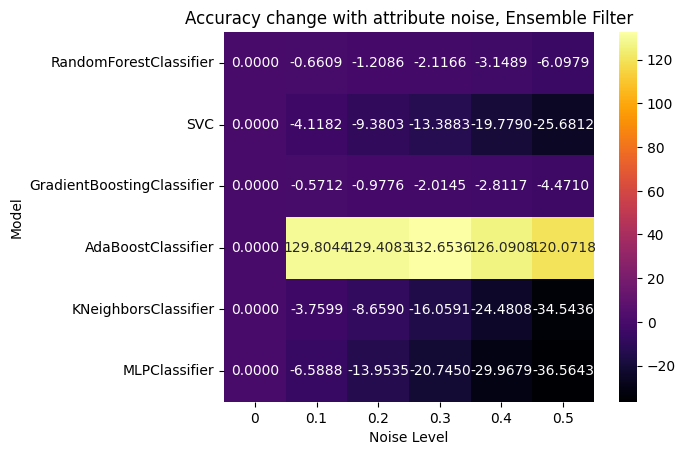

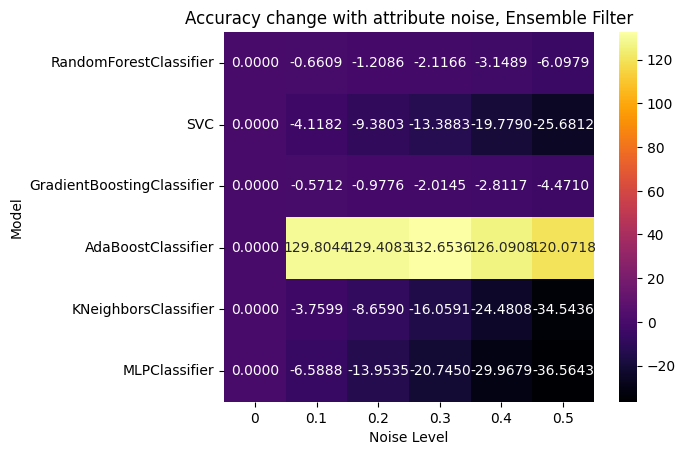
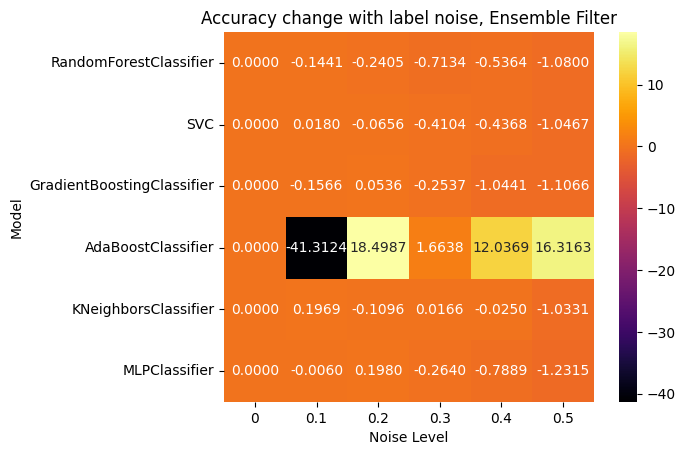

<div style="background-color:#12AA12; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Uklanjanje šuma pomoću ensemble filter znatno poboljšava rezultate u oba slučaja, pa ćemo ga koristiti u konačnom modelu.</li>
</ul>
</div>

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_label_noise_cross_validated_committees_filter], title="Cross Validated Committees Filter")

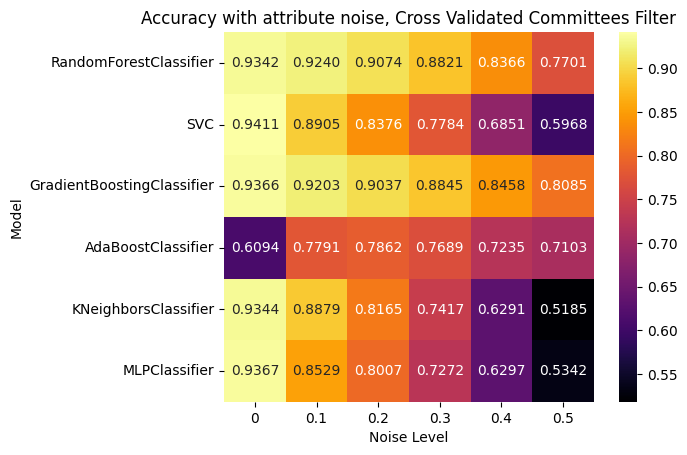
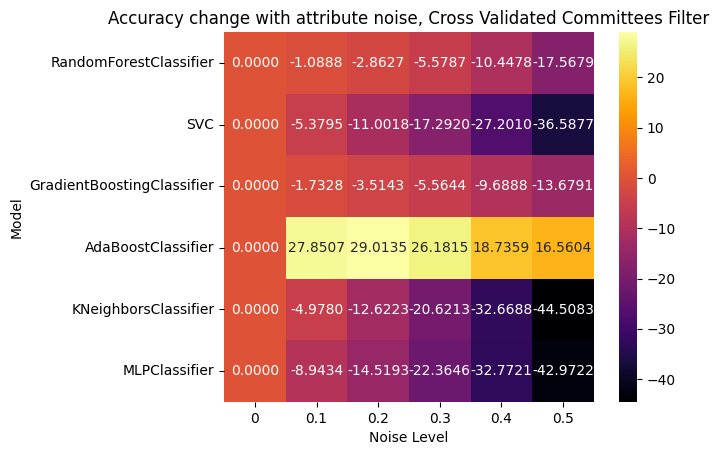

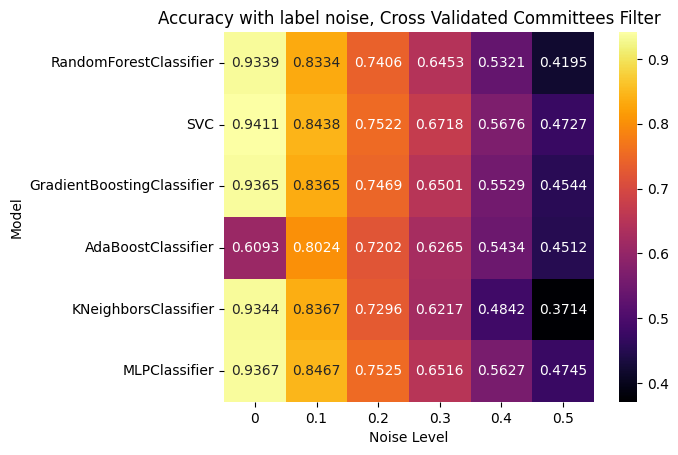
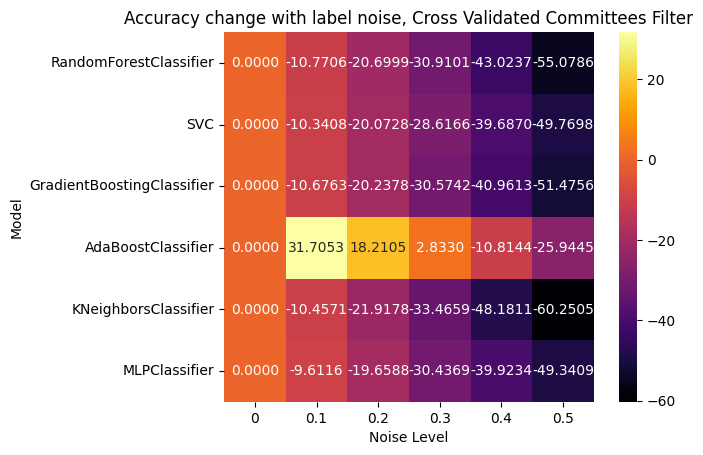

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Uklanjanje šuma pomoću CVCF ne utiče znatno na performanse modela.</li>
</ul>
</div>

In [ ]:
run_models(X_t, y, models, all_res, all_res_change, transforms=[remove_label_noise_iterative_partitioning_filter], title="Iterative Partitioning")

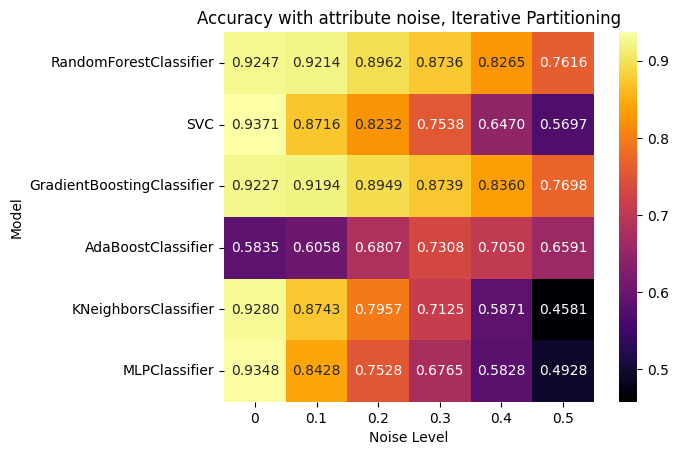
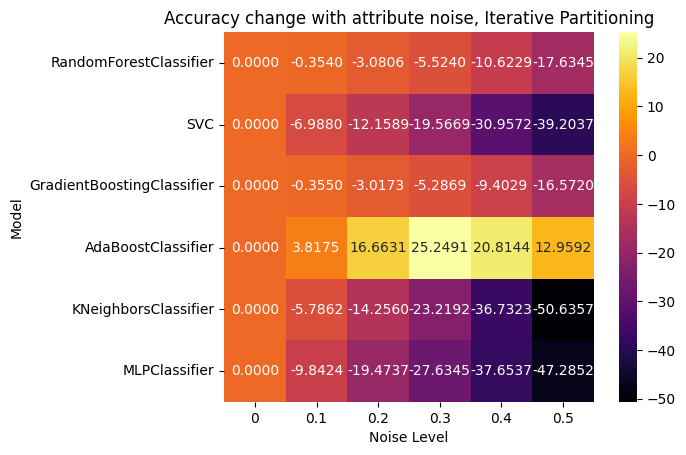

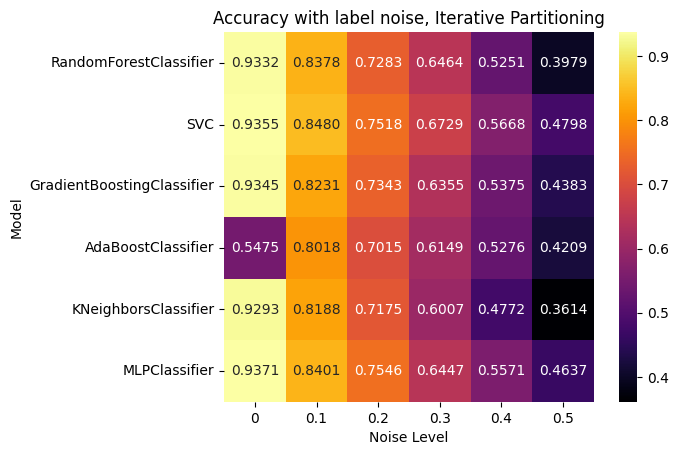
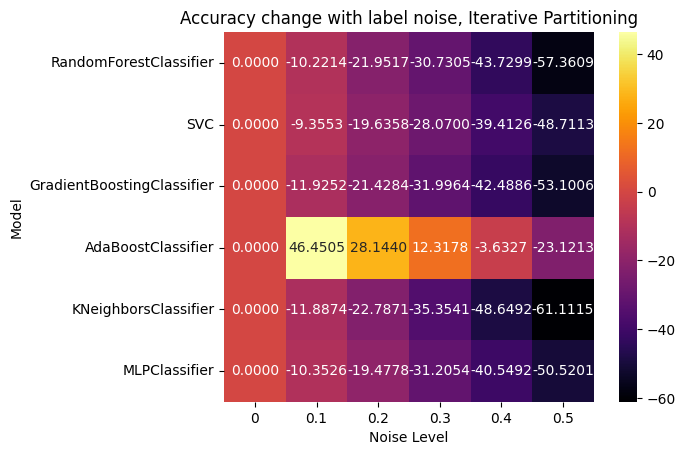

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Uklanjanje šuma pomoću Iterative Partitioning filtra ne utiče znatno na performanse modela.</li>
</ul>
</div>

# OvO i OvR dekompozicija

- **OvO** - One vs One dekompozicija. Ovde ćemo trenirati po jedan model za svaku kombinaciju labela, tj svaki model predviđa da li instanca pripada 1. ili 2. klasa, 1 ili 3. itd. Na kraju se glasanjem odlučuje konačni izlaz skupa modela.
- **OvR** - One vs Rest dekompozicija. Ovde ćemo trenirati po jedan model za svaku labelu, tj svaki model predviđa da li instanca pripada ili ne pripada svakoj od klasa. Na kraju se glasanjem odlučuje konačni izlaz skupa modela.

In [ ]:
feature_num = len(X_t.values[0])
ovo_rfc = (OneVsOneClassifier(RandomForestClassifier(n_jobs=4)), "OvO - RandomForestClassifier")
ovo_svc = (OneVsOneClassifier(SVC()), "OvO - SVC")
ovo_gbc = (OneVsOneClassifier(GradientBoostingClassifier()), "OvO - GradientBoostingClassifier")
ovo_abc = (OneVsOneClassifier(AdaBoostClassifier()), "OvO - AdaBoostClassifier")
ovo_knc = (OneVsOneClassifier(KNeighborsClassifier()), "OvO - KNeighborsClassifier")
ovo_mlp = (OneVsOneClassifier((MLP(hidden_layer_sizes=[16,16,16], alpha=0))), "OvO - MLP")

ovo_models = [ovo_rfc, ovo_svc, ovo_gbc, ovo_abc, ovo_knc, ovo_mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, ovo_models, all_res, all_res_change, transforms=[], title="OvO dekompozicija")

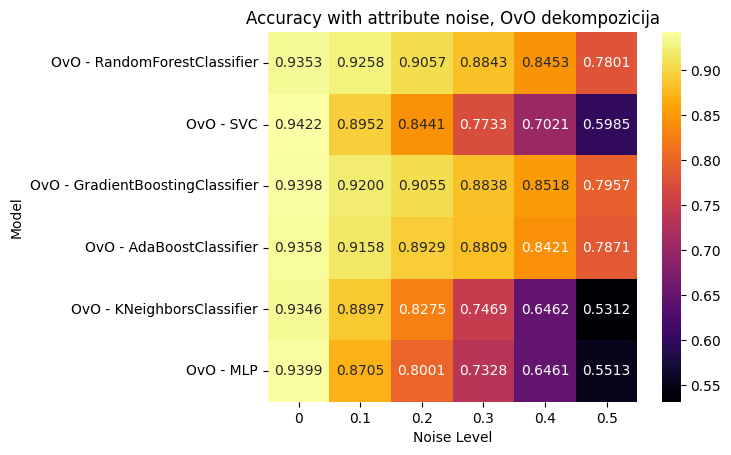
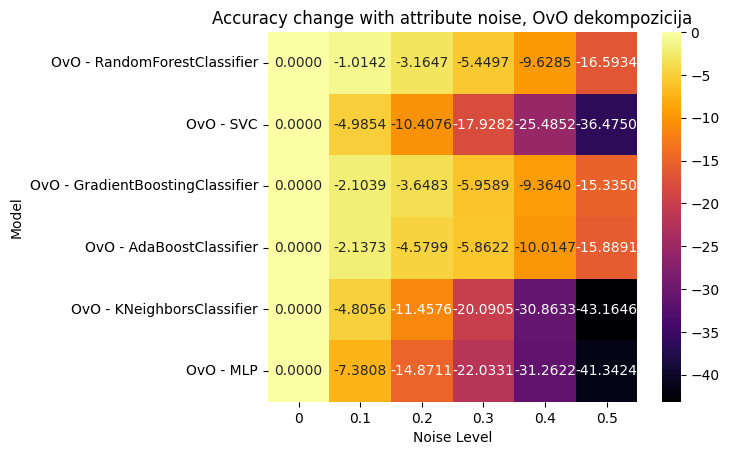

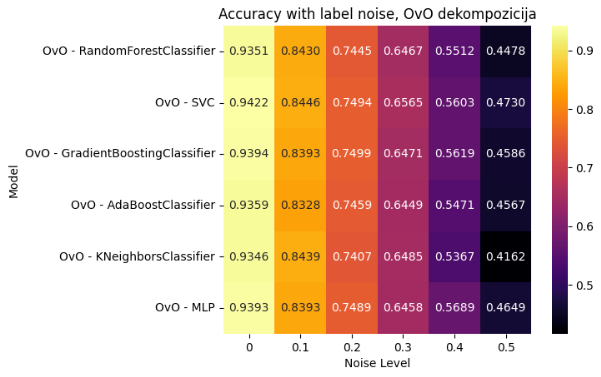
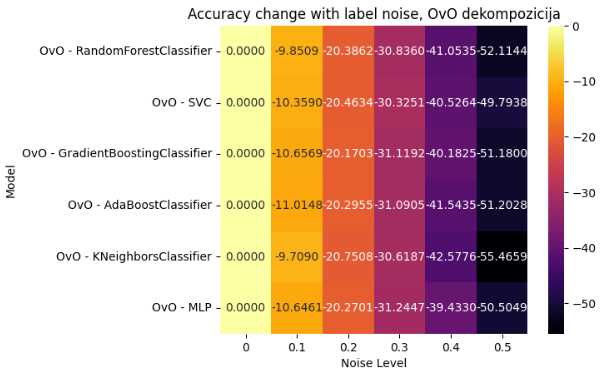

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Korišćenjem OvO dekompozicije dobijamo bolje performanse nego baseline model, tako da ćemo ga koristiti u konačnom modelu</li>
</ul>
</div>

In [ ]:
feature_num = len(X_t.values[0])
ovr_rfc = (OneVsRestClassifier(RandomForestClassifier(n_jobs=4)), "OvR - RandomForestClassifier")
ovr_svc = (OneVsRestClassifier(SVC()), "OvR - SVC")
ovr_gbc = (OneVsRestClassifier(GradientBoostingClassifier()), "OvR - GradientBoostingClassifier")
ovr_abc = (OneVsRestClassifier(AdaBoostClassifier()), "OvR - AdaBoostClassifier")
ovr_knc = (OneVsRestClassifier(KNeighborsClassifier()), "OvR - KNeighborsClassifier")
ovr_mlp = (OneVsRestClassifier(MLP(hidden_layer_sizes=[16,16,16], alpha=0)), "OvR - MLP")

ovr_models = [ovr_rfc, ovr_svc, ovr_gbc, ovr_abc, ovr_knc, ovr_mlp]
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, ovr_models, all_res, all_res_change, transforms=[], title="OvR dekompozicija")

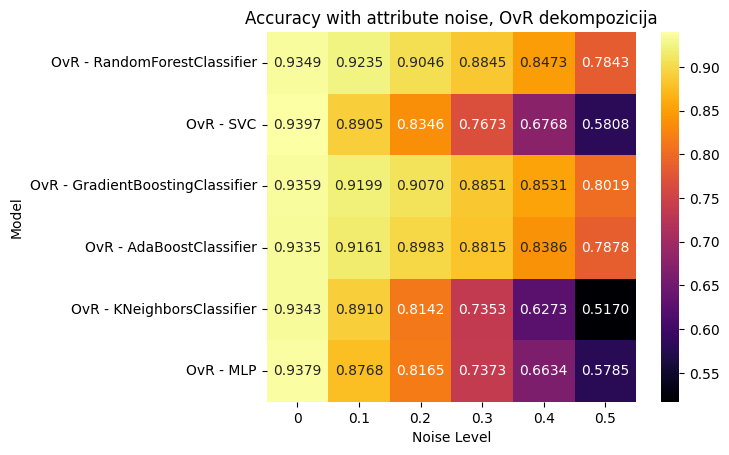
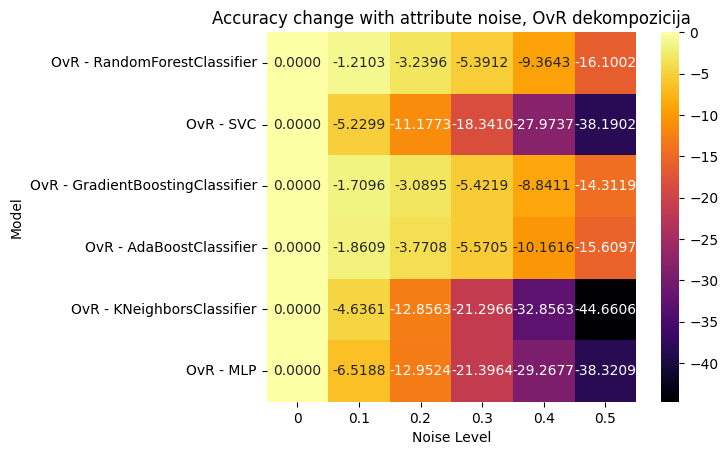

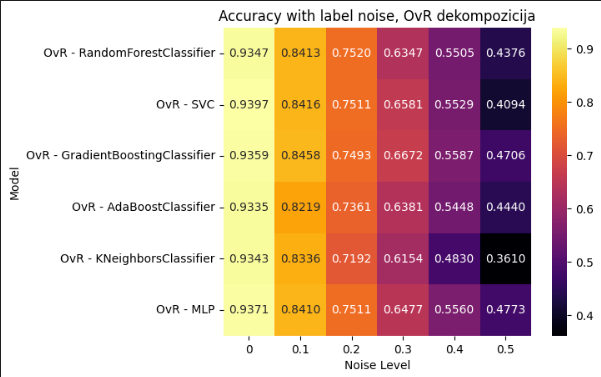
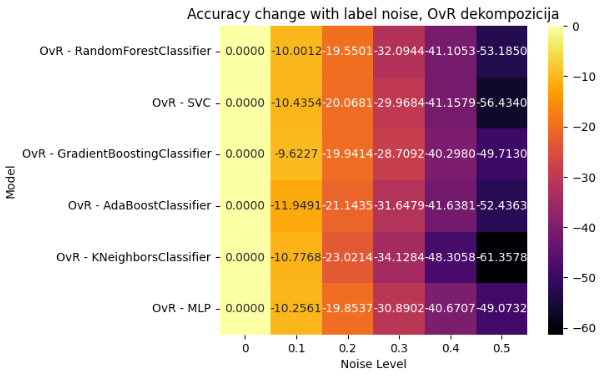

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Korišćenjem OvR dekompozicije dobijamo bolje performanse nego baseline model. U odnosu na OvO, OvR je dao nekada gore nekada bolje performanse kod šuma atributa, međutim kod šuma labela OvO dekompozicija je bilo malo bolja. U konačnom modelu koristićemo OvO.</li>
</ul>
</div>

# MCS

In [ ]:
baseline_acc = np.array([0.7791, 0.6000, 0.8010, 0.7032, 0.5250, 0.5610])
weights = baseline_acc / np.sum(baseline_acc)
weights

In [ ]:
rfc = RandomForestClassifier(n_jobs=4)
svc = SVC()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
knc = KNeighborsClassifier()
mlp = MLP(hidden_layer_sizes=[16,16,16], alpha=0)

ensemble_model = VotingClassifier(estimators=[
    ('RFC', rfc),
    ('SVC', svc),
    ('GBC', gbc),
    ('ABC', abc),
    ('KNC', knc),
    ('MLP', mlp)
], voting='hard', n_jobs=4, weights=weights)
noise_schedule = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
run_models(X_t, y, [(ensemble_model, 'MCS')], all_res, all_res_change, transforms=[], title='MCS')

# Konačni rezultati

- Ubaci sve slike
- Napisi komentare - sta je donelo poboljsanja najveca, komentari
- Sta bi trebala najbolja metoda da bude? Transf+modeli
- Napravi ih, testiraj na trening skupu
- Razlika na test skupu izmedju baseline i najbolje kombinacije

Najbolje se pokazao:
- Random Forest Classifier
- Bez redukcije dimenzionalnosti i regularizacije
- DBSCAN za izbacivanje outliera
- Bez otklanjanja suma atributa
- Ensemble filter za otklanjanje suma labela
- OvO dekompozicija

In [ ]:
best_model = (OneVsOneClassifier(RandomForestClassifier(n_jobs=-1)), "Best")
_, _, models_with_data_noise, models_with_class_noise = run_models(X_t, y, [best_model], all_res, all_res_change, transforms=[remove_outliers_db, remove_label_noise_ensemble_filter], title="With db outlier removal")

### Test skup

In [ ]:
X_test_pt

In [ ]:
y_test

In [ ]:
test_models(X_test_pt, y_test, models_with_data_noise[0])

In [ ]:
test_models(X_test_pt, y_test, models_with_class_noise[0], noise_type="class")

In [ ]:
test_models(X_test_pt, y_test, baseline_att_noise[0])

In [ ]:
test_models(X_test_pt, y_test, baseline_class_noise[0], noise_type="class")

<div style="background-color:#12AA12; height:auto; border-radius:10px; padding:16px; width:1000px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Baseline i najbolji model imaju praktično jednake performanse kada se treniraju nad podacima sa šumom atributa</li>
<li>Međutim, najbolji model pokazuje dosta bolje performanse kada trening skup sadrži šum labela</li>
</ul>
</div>

- Sta ako se primeni na pojedinacnim atributima u x% slucajeva
- Sta ako varira intenzitet suma
=> 3x 2D grafik za svaki model - laki srednji teski
- Sta ako se x% zameni sa random kao do sada
- Sta ako se x% redova zameni labela (ali ne istom labelom!)
=> 3x n*n grafik - n% sum za labele, n% sum klasa
- Sta ako dodamo nove sa sumom
=> da li uspeva da ih izbaci sve, kakve su performanse
- Podela na lake/srednje/teske
    - izdvoji validacioni set i u njemu nadji lake/srednje i teske instance